In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

import torchclustermetrics 
reload(torchclustermetrics)
from torchclustermetrics import silhouette

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans;

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  error_prob  
 0   550.61346   15.421524  18.445875    0.014303  
 1   905.11600   14.925031  31.019386    0.000791  
 2   596.05396   14.681485  22.270780    0.005928  
 3   414.38370   19.306356  16.183300    0.024081  
 4   273.81440   16.112896  26.251837    0.002370  ,
 (43775350, 9))

In [3]:
# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

In [4]:
sum(df_transcripts["error_prob"] > 0.25)

22

In [5]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [6]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [7]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [8]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=5)
clustering.xenium_spot_data.obsm["X_pca"].shape

(6138, 5)

In [52]:
NUM_CLUSTERS = 3
BATCH_SIZE = 256

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

In [53]:
spatial_pca = np.concatenate((clustering.xenium_spot_data.obs[["x_location", "y_location"]], clustering.xenium_spot_data.X), axis=1)
spatial_pca = StandardScaler().fit_transform(spatial_pca)

In [54]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS).fit(spatial_pca)

In [55]:
kmeans_initial_clusters = kmeans.predict(spatial_pca)

In [56]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [57]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(kmeans_initial_clusters.astype(int)) + 1

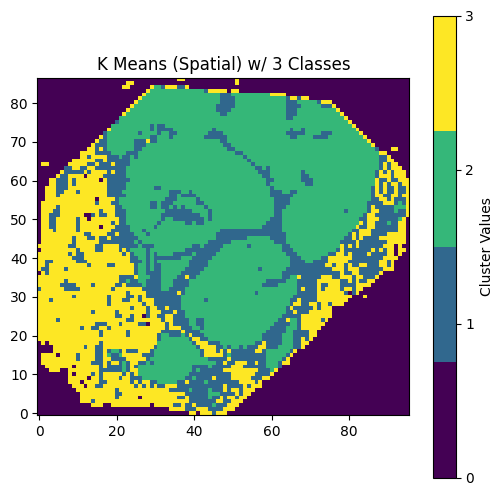

In [58]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title(f'K Means (Spatial) w/ {NUM_CLUSTERS} Classes')
plt.savefig(f"results/hBreast/KMeans/KMeans{NUM_CLUSTERS}Spatial.png")
plt.show()

In [63]:
concentration_priors = torch.tensor(pd.get_dummies(kmeans_initial_clusters, dtype=float).to_numpy())
concentration_w_locations = torch.cat((torch.tensor(clustering.xenium_spot_data.obs[["row", "col"]].to_numpy()), concentration_priors), dim=1)
concentration_w_locations

tensor([[0.1265, 0.1888, 1.0473, 0.1979, 0.1880, 0.0430],
        [0.1522, 0.4338, 1.0435, 0.3602, 0.0388, 0.0175],
        [0.0623, 0.2214, 1.0812, 0.5293, 0.0637, 0.0449],
        ...,
        [0.0837, 0.1868, 1.2293, 0.0207, 0.1415, 0.4433],
        [0.2502, 0.0411, 1.0509, 0.2947, 0.0943, 0.5196],
        [0.1423, 0.0909, 1.1709, 0.0621, 0.0445, 0.4955]], dtype=torch.float64)

In [ ]:
spatial_concentration_priors = concentration_priors.clone()
for concentration, spatial_concentration in zip(concentration_w_locations, spatial_concentration_priors):
    row, col = concentration[:2]
    
    # Apply the conditions for neighborhood
    is_row_near = (concentration_w_locations[:, 0] >= (row - 1)) & (concentration_w_locations[:, 0] <= (row + 1))
    is_col_near = (concentration_w_locations[:, 1] >= (col - 1)) & (concentration_w_locations[:, 1] <= (col + 1))
    
    # Combine the row and column conditions
    neighborhood_mask = is_row_near & is_col_near
    
    # Select the neighborhood based on the mask
    neighborhood = concentration_priors[neighborhood_mask]
    
    # Compute the mean of the data columns in the neighborhood
    mean_values = neighborhood.mean(dim=0)
    
    # Assign the mean back to the corresponding locations in the original tensor (modify this as needed)
    spatial_concentration += mean_values

In [ ]:
concentration_priors = spatial_concentration_priors
concentration_priors += torch.distributions.half_normal.HalfNormal(0.2).sample((concentration_priors.shape))
torch.round(concentration_priors, decimals=4)

In [64]:
# Load the data, which is just all expressions now (not PCA)

# TO DO: MAKE THIS ONLY HVG
data = torch.tensor(clustering.xenium_spot_data.X).float()

In [65]:
def model(data):
    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_concentration_priors))
        
        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        
        # Likelihood of data given cluster assignments
        pyro.sample("obs", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs).to_event(1), obs=batch_data)

def guide(data):
    MIN_CONCENTRATION = 0.1
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", torch.ones(data.size(0), NUM_CLUSTERS), constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    cluster_means_q = pyro.param("cluster_means_q", torch.randn(NUM_CLUSTERS, data.size(1)))
    cluster_scales_q = pyro.param("cluster_scales_q", torch.ones(NUM_CLUSTERS, data.size(1)), constraint=dist.constraints.positive)
    
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind]

        # pyro.sample("cluster_assignments", dist.Categorical(batch_cluster_probs_q))
        pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))
        pyro.sample("cluster_means", dist.Normal(cluster_means_q, 0.1).to_event(2))
        pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 0.1).to_event(2))

In [69]:
from pyro.optim import PyroOptim, PyroLRScheduler
from torch.optim import Adam, lr_scheduler

starting_lr = 0.01
ending_lr = 0.00001
N_STEPS = 1000

# Setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = PyroOptim(Adam, adam_params)
scheduler = PyroLRScheduler(lr_scheduler.StepLR, {'optimizer': Adam, 'optim_args': {'lr': starting_lr}, 'step_size': 1, 'gamma': (ending_lr / starting_lr) ** (1 / N_STEPS)})

In [70]:
# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=1))

In [71]:
for step in range(N_STEPS):
    loss = svi.step(data)
    svi.optim.step()
    if step % 5 == 0:
        print(step)
    if step % 100 == 0:
        print(f"Step {step} : loss = {round(loss/1e6, 4)}")

0
Step 0 : loss = 1081.6487
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
Step 100 : loss = 877.9467
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
Step 200 : loss = 807.4929
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
Step 300 : loss = 783.3975
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
Step 400 : loss = 771.5223
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
Step 500 : loss = 773.7475
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
Step 600 : loss = 768.4984
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
Step 700 : loss = 771.9046
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
Step 800 : loss = 768.6442
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
Step 900 : loss = 762.3486
905
910
915
920
925
930
935
9

In [79]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()
cluster_concentration_params_q = cluster_concentration_params_q.detach()

cluster_assignments_q = cluster_probs_q.argmax(dim=1)
cluster_means_q = pyro.param("cluster_means_q").detach()
cluster_scales_q = pyro.param("cluster_scales_q").detach()

# Output the learned cluster probabilities for each data point
print(cluster_assignments_q, cluster_probs_q)

tensor([2, 0, 3,  ..., 2, 2, 0]) tensor([[0.0217, 0.0094, 0.4356, 0.1141, 0.2172, 0.2020],
        [0.4903, 0.3034, 0.0394, 0.0785, 0.0247, 0.0637],
        [0.2817, 0.0054, 0.1094, 0.2869, 0.2009, 0.1157],
        ...,
        [0.0109, 0.1313, 0.5966, 0.0468, 0.0319, 0.1825],
        [0.2302, 0.1349, 0.2803, 0.0255, 0.1886, 0.1404],
        [0.3572, 0.2004, 0.0456, 0.0015, 0.1897, 0.2055]])


(array([ 898.,    0.,  876.,    0., 1067.,    0., 1086.,    0.,  880.,
        1331.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

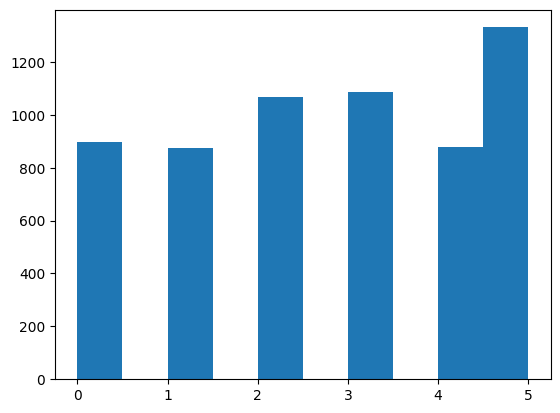

In [80]:
plt.hist(cluster_assignments_q)

In [81]:
np.set_printoptions(suppress=True) 
np.round(cluster_means_q, 4), np.round(cluster_scales_q, 4)

(tensor([[ 3.6690e-01, -1.6110e-01,  1.3560e-01,  ...,  4.7660e-01,
           1.4815e+00,  7.9280e-01],
         [-6.7700e-01, -1.4160e-01,  1.2000e-02,  ...,  3.4000e-03,
           2.0000e-04, -3.7050e-01],
         [ 9.1200e-02,  5.8740e-01,  9.1900e-01,  ...,  1.0826e+00,
           1.8759e+00,  7.1650e-01],
         [ 1.0146e+00,  1.8516e+00,  2.3346e+00,  ...,  2.5001e+00,
           2.2400e+00,  3.5740e-01],
         [ 4.0000e-04,  1.5170e-01,  2.8500e-02,  ...,  8.2600e-02,
           2.8140e-01, -3.1260e-01],
         [ 2.9865e+00,  1.2099e+00,  3.0118e+00,  ...,  1.7636e+00,
           2.6353e+00,  1.0851e+00]]),
 tensor([[0.7390, 1.1500, 0.6763,  ..., 0.7334, 0.7606, 0.7249],
         [0.4036, 0.4027, 0.4325,  ..., 0.4330, 0.4273, 0.4124],
         [0.2300, 0.6083, 0.2563,  ..., 0.2592, 0.2731, 0.2348],
         [0.3242, 0.8487, 0.2969,  ..., 0.2910, 0.4668, 0.8466],
         [0.6501, 0.5641, 0.6421,  ..., 0.6208, 0.6005, 0.5991],
         [0.3150, 1.0935, 0.3004,  ..., 0.2

In [82]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [83]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = cluster_assignments_q + 1

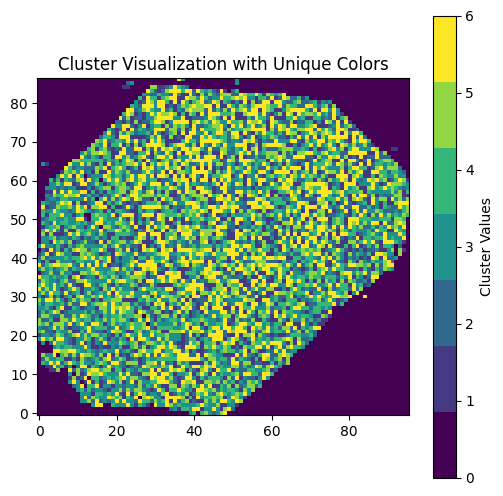

In [84]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

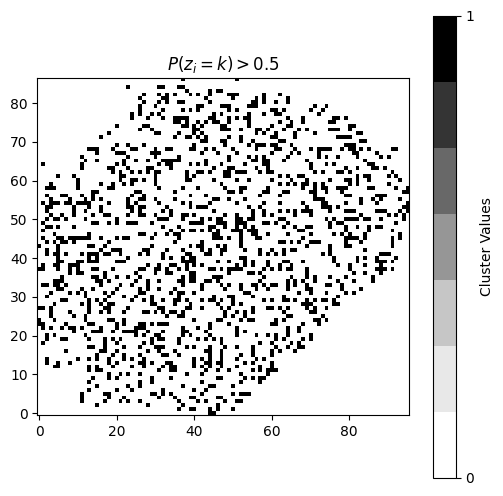

In [85]:
# confidence mapping
cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.float)

cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

colors = plt.cm.get_cmap('Greys', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences > 0.5, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title(r'$P(z_i = k) > 0.5$')
plt.show()